In [32]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
## Use the ggplot style
plt.style.use('ggplot')

# Modelling Joint distribution (Bursera and Joint)
The data is taken from the Redis database. 
This mimics the process performed in the cluster or other independent computing infrastructures.

We will use the functions defined in spystats.biospytial_models

In [33]:
import external_plugins.spystats.biospytial_models.runner as bm

In [34]:
import redis
conn = redis.StrictRedis(host='redis',password='biospytial.')

In [35]:
trainkey = 't-puebla-p2-abies-pinophyta'
predkey = 'p-100x100-puebla-poly2'

PDF = bm.preparePredictors(bm.loadDataFrameFromRedis(predkey,conn))
TDF = bm.loadDataFrameFromRedis(trainkey,conn)

INFO:external_plugins.spystats.biospytial_models.runner:Loading data from RedisDB
INFO:external_plugins.spystats.biospytial_models.runner:Loading data from RedisDB


In [36]:
## Associate the categorical variables
TDF['name'] = TDF['name'].astype('category')
TDF['wwf_mhtnam'] = TDF['wwf_mhtnam'].astype('category')
TDF['tipos'] = TDF['tipos'].astype('category')

PDF['clean']['name'] = PDF['clean']['name'].astype('category')
PDF['clean']['wwf_mhtnam'] = PDF['clean']['wwf_mhtnam'].astype('category')
PDF['clean']['tipos'] = PDF['clean']['tipos'].astype('category')

PDF['full']['name'] = PDF['full']['name'].astype('category')
PDF['full']['wwf_mhtnam'] = PDF['full']['wwf_mhtnam'].astype('category')
PDF['full']['tipos'] = PDF['full']['tipos'].astype('category')



/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

In [37]:
#formula_S = 'Burseraceae ~ Longitude + Latitude + Elevation_m + MaxTemp_m + MeanTemp_m + SolarRadiation_m + VaporPres_m '
formula_S= 'Pinophyta ~ Longitude + Latitude + Q("Dist.to.road_m") + Population_m + tipos'
formula_P = 'Abies ~  Longitude + Latitude + Elevation_m + MeanTemp_m  '

In [38]:
TM_S,PM_S = bm.splitByFormula(formula_S,TDF,PDF['clean'])
TM_P,PM_P = bm.splitByFormula(formula_P,TDF,PDF['clean'])

INFO:external_plugins.spystats.biospytial_models.runner:Creating Design matrices from the formula Pinophyta ~ Longitude + Latitude + Q("Dist.to.road_m") + Population_m + tipos
INFO:external_plugins.spystats.biospytial_models.runner:Creating Design matrices from the formula Abies ~  Longitude + Latitude + Elevation_m + MeanTemp_m  


In [39]:
import pymc3 as pm
import theano.tensor as tt
trainDM_S = TM_S
PredDM_S = PM_S
trainDM_P = TM_P
PredDM_P = PM_P

### This is just a sandbox
First, I want to generate an appropriate dataset for $$Y =  [S1,S2] $$ and for the co-regionalization model:

$$ [S_1,S_2]^{t} = \sum_{j=1}^{p} R(\phi_j) \otimes a_{j}a_{j}^{T} = \Sigma_{{Y}} $$






In [40]:
TX1 = TM_P[1][['Longitude','Latitude']]
TY1 = TM_P[1][['MeanTemp_m']]
TX2 = TM_S[1][['Longitude','Latitude']]
TY2 = TM_S[1][['Population_m']]
idx_0 = pd.DataFrame(np.zeros(len(TX1)))
idx_1 = pd.DataFrame(np.zeros(len(TX2)) + 1)
idx_ = pd.concat([idx_0,idx_1]).astype(int)

TX = pd.concat([TX1,TX2])
TX = pd.concat([TX,TX],axis =1)
TX = pd.concat([TX,idx_],axis=1)
Y = np.vstack([TY1.values,TY2.values])

alterTX = pd.concat([TX1,TX2,TY1,TY2],axis=1)


In [41]:
TX.shape

(758, 5)

In [28]:
#....! Nailed it ??
# Noooo!

In [42]:
trainDM_S = TM_S
PredDM_S = PM_S
trainDM_P = TM_P
PredDM_P = PM_P

# partition dataframes df
Y_Sdf = trainDM_S[0]
TX_Sdf = trainDM_S[1]
txcols_s = set(TX_Sdf.columns)
pxcols_s = set(PredDM_S.columns)
common_cols_s = list(txcols_s & pxcols_s)
TX_Sdf = TX_Sdf[common_cols_s]
PX_Sdf = PredDM_S[common_cols_s]
PredX_S = PX_Sdf.values

# partition dataframes df
Y_Pdf = trainDM_P[0]
TX_Pdf = trainDM_P[1]
txcols_p = set(TX_Pdf.columns)
pxcols_p = set(PredDM_P.columns)
common_cols_p = list(txcols_p & pxcols_p)
TX_Pdf = TX_Pdf[common_cols_p]
PX_Pdf = PredDM_P[common_cols_p]
PredX_P = PX_Pdf.values


## The latent function
xs_index = TX_Sdf.columns.get_loc(b"Longitude")
ys_index = TX_Sdf.columns.get_loc(b"Latitude")

## The latent function
xp_index = TX_Pdf.columns.get_loc(b"Longitude")
yp_index = TX_Pdf.columns.get_loc(b"Latitude")

  
TX1 = TX_Sdf[['Longitude','Latitude']]
TY1 = TX_Sdf[['Population_m']]
TX2 = TX_Pdf[['Longitude','Latitude']]
TY2 = TX_Pdf[['MeanTemp_m',]]


In [43]:
### Candidate
with pm.Model() as model:
    sigma_p = pm.HalfNormal('sigma_p',sd=2)
    phi_p = pm.HalfNormal('phi_p',sd=1)
    cov_p= sigma_p * pm.gp.cov.Matern32(2,phi_p,active_dims=[0,1])
    sigma_s = pm.HalfNormal('sigma_s',sd=3)
    phi_s = pm.HalfNormal('phi_s',sd=1)
    cov_s= sigma_s * pm.gp.cov.Matern32(2,phi_s,active_dims=[0,1])
    A = pm.HalfNormal('A',sd=1,shape=(2,2))
    T = pm.Deterministic('T',pm.math.dot(A,A.T))
    K1= tt.slinalg.kron(cov_p(TX1.values),T)
    K2= tt.slinalg.kron(cov_s(TX2.values),T)
    K = K1 + K2
    mu = tt.zeros(TX.shape[0])
    y = pm.MvNormal('y',mu=mu,cov=K,observed=Y)
    for RV in model.basic_RVs:
        print(RV.name, RV.logp(model.test_point))
    #gp = pm.gp.Latent(cov_func=K)
    #f = gp.prior("latent_field", X=TX.values,reparameterize=False)
    #y_obs = pm.Bernoulli('y_obs',logit_p=f,observed=Y)
    #K1.eval()

('sigma_p_log__', array(-0.76989259))
('phi_p_log__', array(-0.76989259))
('sigma_s_log__', array(-0.76989259))
('phi_s_log__', array(-0.76989259))
('A_log__', array(-3.07957037))
('y', array(-inf))


In [44]:
with model:
    
    #step = pm.Metropolis()
    tr = pm.sample(500)#,step)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, phi_s, sigma_s, phi_p, sigma_p]
INFO:pymc3:NUTS: [A, phi_s, sigma_s, phi_p, sigma_p]


IOError: [Errno 28] No space left on device

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b24ec5b50>,
      dtype=object)

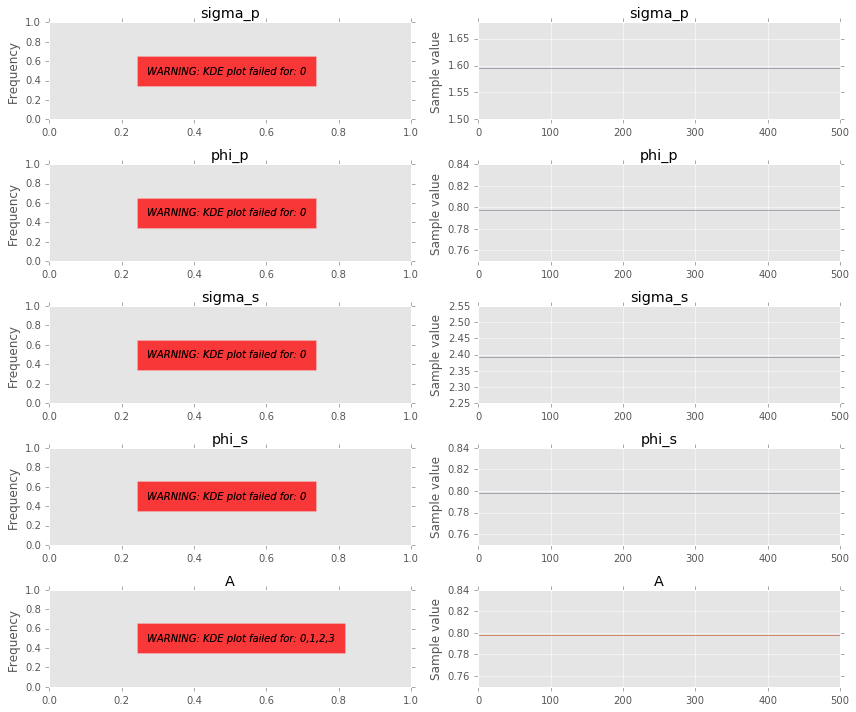

In [21]:
pm.traceplot(tr)

In [14]:
### Example of Coregion

In [43]:
with pm.Model() as model:
    ## Building the covariance structure
    #sigma_p = pm.HalfNormal('sigma_p',sd=3)
    #phi = pm.Uniform('phi',0,15)
    phi_p = pm.HalfNormal('phi_p',sd=1)
    cov_p= pm.gp.cov.Matern32(2,phi_p,active_dims=[0,1])

    ## Building the covariance structure
    #sigma_s = pm.HalfNormal('sigma_s',sd=3)
    #phi = pm.Uniform('phi',0,15)
    phi_s = pm.HalfNormal('phi_s',sd=1)
    cov_s= pm.gp.cov.Matern32(2,phi_s,active_dims=[0,1])

    ## Build corregionalization matrix
    #A = pm.Normal(name='a',mu=0,sd=1,shape=(2,2))
    ### Letś try to do the exercise with kronnecker prod 
    
    A = pm.gp.cov.Coregion(2,active_dims=[2])
    fl1 = [A,cov_p]
    fl2 = [A,cov_s]
    K1 = pm.gp.cov.Kron(factor_list=fl1)
    K2 = pm.gp.cov.Kron(factor_list=fl2)
    K = K1 + K2
    
    gp = pm.gp.Latent(cov_func=K)
    
    f = gp.prior("latent_field", X=TX.values,reparameterize=False)
    
    y_obs = pm.Bernoulli('y_obs',logit_p=f,observed=Y)

ValueError: Exactly one of (W, kappa) and B must be provided to Coregion

In [ ]:


    
with pm.Model() as model:

    # partition dataframes df
    Y_Sdf = trainDM_S[0]
    TX_Sdf = trainDM_S[1]
    txcols_s = set(TX_Sdf.columns)
    pxcols_s = set(PredDM_S.columns)
    common_cols_s = list(txcols_s & pxcols_s)
    TX_Sdf = TX_Sdf[common_cols_s]
    PX_Sdf = PredDM_S[common_cols_s]
    PredX_S = PX_Sdf.values

   ## Parameters for linear predictor
   ## Create theano vector
    betas_s = []
    for n in common_cols_s:
        n = n.replace('"', '').replace("'", '').replace(' ', '').replace(',','')
        b = pm.Normal(name='bs_' + n ,mu=0,sd=1.5)
        betas_s.append(b)
    B_S = tt.stack(betas_s,axis=0).T

    # partition dataframes df
    Y_Pdf = trainDM_P[0]
    TX_Pdf = trainDM_P[1]
    txcols_p = set(TX_Pdf.columns)
    pxcols_p = set(PredDM_P.columns)
    common_cols_p = list(txcols_p & pxcols_p)
    TX_Pdf = TX_Pdf[common_cols_p]
    PX_Pdf = PredDM_P[common_cols_p]
    PredX_P = PX_Pdf.values

   ## Parameters for linear predictor
   ## Create theano vector
    betas_p = []
    for n in common_cols_p:
        n = n.replace('"', '').replace("'", '').replace(' ', '').replace(',','')
        b = pm.Normal(name='bp_' + n ,mu=0,sd=1.5)
        betas_p.append(b)
    B_P = tt.stack(betas_p,axis=0).T    
    
    ## The latent function
    xs_index = TX_Sdf.columns.get_loc(b"Longitude")
    ys_index = TX_Sdf.columns.get_loc(b"Latitude")
    
    ## The latent function
    xp_index = TX_Pdf.columns.get_loc(b"Longitude")
    yp_index = TX_Pdf.columns.get_loc(b"Latitude")

    ## Building the covariance structure
    sigma_p = pm.HalfNormal('sigma_p',sd=3)
    #phi = pm.Uniform('phi',0,15)
    phi_p = pm.HalfNormal('phi_p',sd=1)
    cov_p= sigma_p * pm.gp.cov.Matern32(2,phi_p,active_dims=[xp_index,yp_index])

    ## Building the covariance structure
    sigma_s = pm.HalfNormal('sigma_s',sd=3)
    #phi = pm.Uniform('phi',0,15)
    phi_s = pm.HalfNormal('phi_s',sd=1)
    cov_s= sigma_s * pm.gp.cov.Matern32(2,phi_s,active_dims=[xs_index,ys_index])

    ## Build corregionalization matrix
    A = pm.Normal(name='a',mu=0,sd=1).shape(2,2)
    ### Letś try to do the exercise with kronnecker prod 
    
    K1 = pm.gp.cov.Kron([A,cov_p])
    K2 = pm.gp.cov.Kron([A,cov_s])
    K = K1 + K2
    
    gp = pm.gp.Latent(cov_func=K)
    
    ## Build the joint-covariance matrix
    #mp,np = TM_P[1].shape
    #ms,ns = TM_S[1].shape
    
    #S = cov_s(TM_S[1].values)## Eval is wrong.eval()
    ## Creo la clave esta aqui:https://docs.pymc.io/notebooks/GP-MeansAndCovs.html 
    #P = cov_p(TM_P[1].values).eval()
    #C = tt.identity_like(S)
    
    #A = tt.concatenate([S,C],axis=1)
    #B = tt.concatenate([C.T,P],axis=1)
    #K = tt.concatenate([A,B],axis=0)
    
   # KS = cov_s.eval()

    #mean_f = pm.gp.mean.Linear(coeffs=B)

    #gp = pm.gp.Latent(cov_func=K)

    
    f = gp.prior("latent_field", Xs=TM_S.values)


    yy = pm.Bernoulli("yy",logit_p=f,observed=Ydf.values)




    

In [232]:

    ## Building the covariance structure
with pm.Model() as model:  
    sigma_p = pm.HalfNormal('sigma_p',sd=3)
    #phi = pm.Uniform('phi',0,15)
    phi_p = pm.HalfNormal('phi_p',sd=1)

    d = 2
    m = []

        
    #B_P = tt.stack(betas_p,axis=0).T    
    

    cov_p= (sigma_p * pm.gp.cov.Matern32(2,phi_p,active_dims=[0,1]))


    ## Building the covariance structure

    sigma_s = pm.HalfNormal('sigma_s',sd=3)
    #phi = pm.Uniform('phi',0,15)
    phi_s = pm.HalfNormal('phi_s',sd=1)

    cov_s= (sigma_s * pm.gp.cov.Matern32(2,phi_s,active_dims=[0,1]))

    for n in range(d*d):
        #n = n.replace('"', '').replace("'", '').replace(' ', '').replace(',','')
        s = pm.Normal(name='s_' + str(n) ,mu=0,sd=1.5)
        m.append(s)    
    ### Letś try to do the exercise with kronnecker prod
    ns = TX1.shape[0]
    np_ = TX2.shape[0]
    S = pm.MvNormal('S',mu=np.zeros(ns),cov=cov_s(TX1))
    P = pm.MvNormal('P', mu=np.zeros(np_),cov=cov_p(TX2))
    
    M = tt.eye(4)
    for i in range(2):
        for j in range(2):
            M = tt.set_subtensor(M[i,j],m.pop())
            
    #gp = pm.gp.MarginalKron(cov_funcs=[cov_p,cov_s])
    
   
    #TX = pd.concat([TX1,TX2],axis=1)
    #TY = pd.concat([TY1,TY2],axis=1).values
    #Y = pm.math.cartesian(TY1.values,TY2.values)
    
    #f = gp.prior("latent_field", X=T)
    #XXs = [TX1.values,TX2.values]
    #YYs = [TY1.values,TY2.values]
    #y_ = gp.marginal_likelihood('y',Xs=XXs,y=Y,sigma=sigma_p)

    #yy = pm.Bernoulli("yy",logit_p=f,observed=Ydf.values)




    

TypeError: unhashable type

In [44]:
points_p = TM_P[1][['Longitude','Latitude']]
points_s = TM_S[1][['Longitude','Latitude']]

In [152]:
np.random.seed(1234)

# One dimensional column vectors of inputs
n1, n2 = (50, 30)
x1 = np.linspace(0, 5, n1)
x2 = np.linspace(0, 3, n2)

# make cartesian grid out of each dimension x1 and x2
X = pm.math.cartesian(x1[:,None], x2[:,None])

l1_true = 0.8
l2_true = 1.0
eta_true = 1.0

# Although we could, we don't exploit kronecker structure to draw the sample
cov = eta_true**2 * pm.gp.cov.Matern52(2, l1_true, active_dims=[0]) *\
                    pm.gp.cov.Cosine(2, ls=l2_true, active_dims=[1])

K = cov(X).eval()
f_true = np.random.multivariate_normal(np.zeros(X.shape[0]), K, 1).flatten()

sigma_true = 0.25
y = f_true + sigma_true * np.random.randn(X.shape[0])


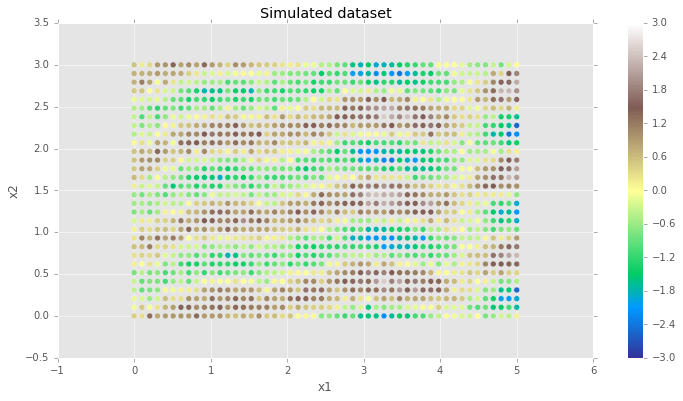

In [153]:
import matplotlib as mpl
fig = plt.figure(figsize=(12,6))
ax = fig.gca(); cmap = 'terrain'
norm = mpl.colors.Normalize(vmin=-3, vmax=3)
plt.scatter(X[:,0], X[:,1], s=35, c=y, marker='o', norm=norm, cmap=cmap); plt.colorbar();
plt.xlabel("x1"); plt.ylabel("x2"); plt.title("Simulated dataset");

In [154]:
Xs = [x1[:,None], x2[:,None]]

with pm.Model() as model:
    # Set priors on the hyperparameters of the covariance
    ls1  = pm.Gamma("ls1", alpha=2, beta=2)
    ls2  = pm.Gamma("ls2", alpha=2, beta=2)
    eta = pm.HalfNormal("eta", sd=2)

    # Specify the covariance functions for each Xi
    # Since the covariance is a product, only scale one of them by eta.
    # Scaling both overparameterizes the covariance function.
    cov_x1 = pm.gp.cov.Matern52(1, ls=ls1)        # cov_x1 must accept X1 without error
    cov_x2 = eta**2 * pm.gp.cov.Cosine(1, ls=ls2) # cov_x2 must accept X2 without error

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.MarginalKron(cov_funcs=[cov_x1, cov_x2])

    # Set the prior on the variance for the Gaussian noise
    sigma = pm.HalfNormal("sigma", sd=2)

    # Place a GP prior over the function f.
    y_ = gp.marginal_likelihood("y", Xs=Xs, y=y, sigma=sigma)

In [125]:
Xs.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
model,gp = bm.ModelSamplingEffort(TM,PM)

In [ ]:
#trace = bm.SampleModel(model,inference_method='advi',ncores=3,niters=15000)
trace = bm.SampleModel(model,inference_method='mcmc',ncores=3,niters=1500)

INFO:external_plugins.spystats.biospytial_models.runner:Selected inference method: MCMC  n_iters 1500, njobs 3
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [latent_field, phi_log__, sigma_log__, tau_log__, b_MaxTemp_m, b_Latitude, b_Elevation_m, b_Intercept, b_Longitude, b_SolarRadiation_m, b_VaporPres_m, b_MeanTemp_m]
INFO:pymc3:NUTS: [latent_field, phi_log__, sigma_log__, tau_log__, b_MaxTemp_m, b_Latitude, b_Elevation_m, 

In [22]:
import pymc3 as pm

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1e629d8d0>,
      dtype=object)

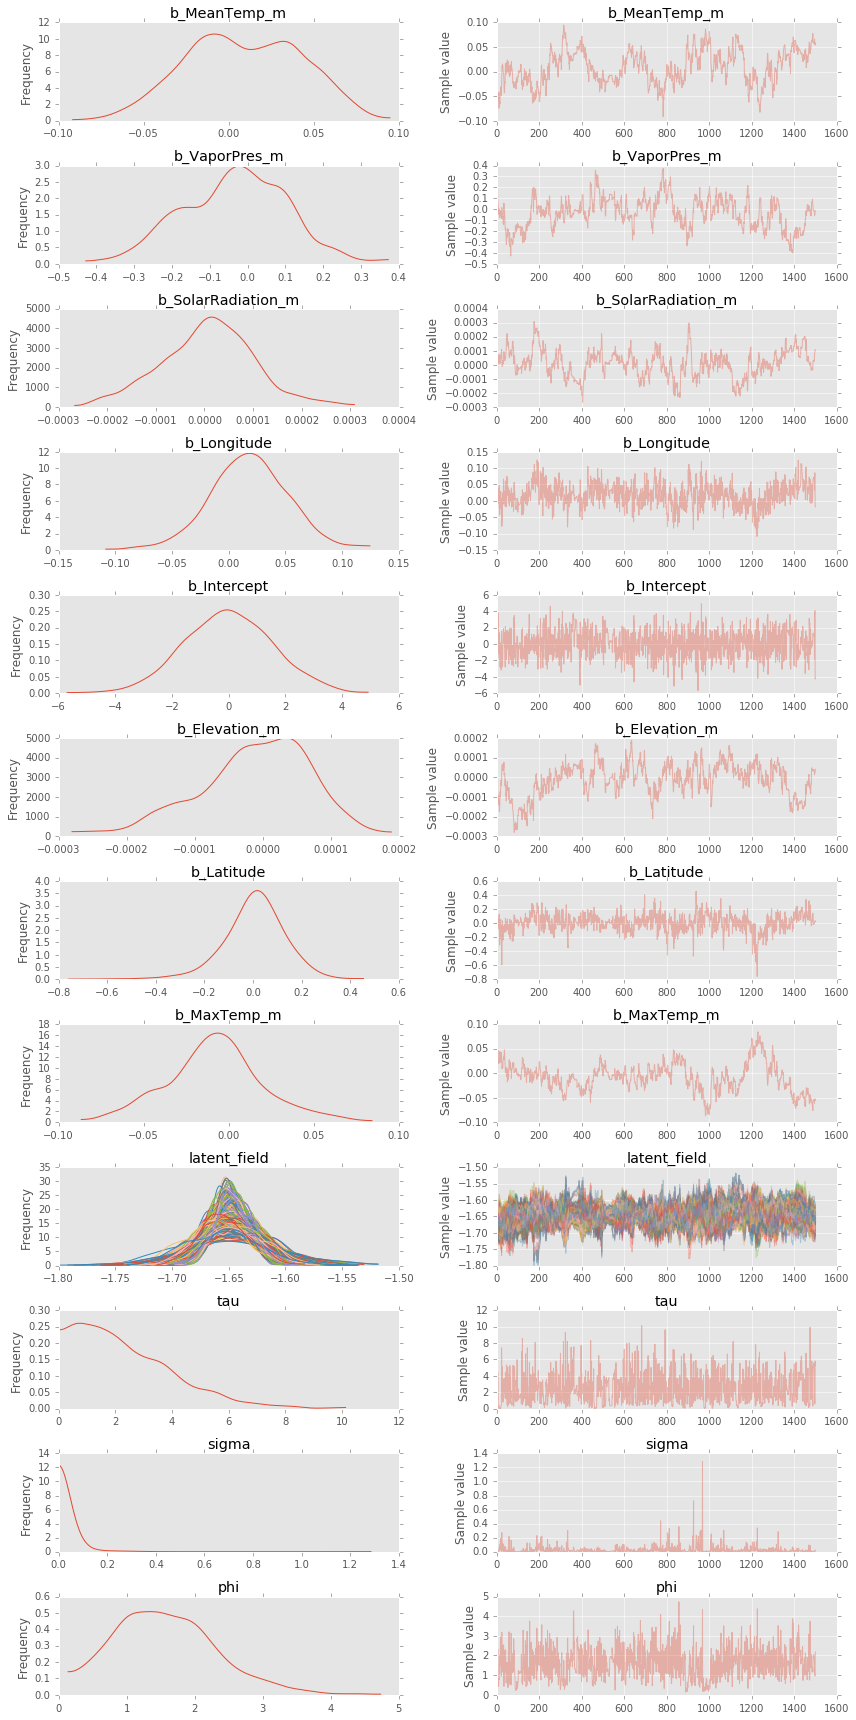

In [23]:
 pm.traceplot(trace)

In [ ]:
%time pred_samples = bm.SamplePredictions(model,gp,TM,PM,trace)

In [24]:
pred_samples['f_star'].shape

(300, 7375)

# Recreate the Raster Container
Let's create the raster container.

In [25]:
from django.contrib.gis.geos import Point, Polygon
xcoord = -99.76
ycoord = 17.55
p = Point(xcoord,ycoord,srid=4326)
radii = np.linspace(0.08,1, 10)
polys = map(lambda r : p.buffer(r),radii)

In [41]:


from scipy import special as sp

alpha = sp.logit(0.5)
preds = pd.DataFrame(pred_samples['f_star']).transpose()
prob_gt05 = preds.apply(lambda row : float(sum(row > alpha))/len(row),axis=1)
mean_sample = preds.mean(axis=1)
q_025 = preds.quantile(0.025,axis=1)
q_975 = preds.quantile(0.975,axis=1)
median = preds.median(axis=1)
var = preds.var(axis=1)
surface_data = pd.DataFrame({'mean_sample' : mean_sample, 'q_025':q_025,'q_975':q_975,'p_ex50':prob_gt05,'vari':var,'median_':median})
#preds['idx'] = data_star.index.values
surface_data['idx'] = PDF['clean'].index.values
predictions = PDF['full'].merge(surface_data,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))

In [ ]:
plt.scatter(predictions.Longitude,predictions.Latitude,c=predictions.mean_sample)

In [27]:
from raster_api.models import raster_models as models
from raster_api.tools import RasterData, RasterContainer
import utilities.data_extraction as de
from datapipelines import paper2 as p2
#from ecoregions.models import TerrEcoregions,InegiIV
#vectsel = [[TerrEcoregions,['wwf_mhtnum','wwf_mhtnam'],[np.nan,'NaN']],[InegiIV,['covid','name'],[np.nan,'NaN']]]
polys = [polys[4]]    

In [31]:
#import django.db as db
#db.close_old_connections()

In [32]:
datasets = map(lambda polygon : de.compilePredictorRasterStack(polygon,100,100,models,as_dataframe=False),polys[:4])

INFO Alligning stacked raster data to common origin...
INFO:biospytial.raster_api.tools:Alligning stacked raster data to common origin...


In [33]:
plt.rcParams['figure.figsize'] = [10, 10]

## Examine covariates:
These are:
     * Distance to Road
     * Population density
     * vegetation type


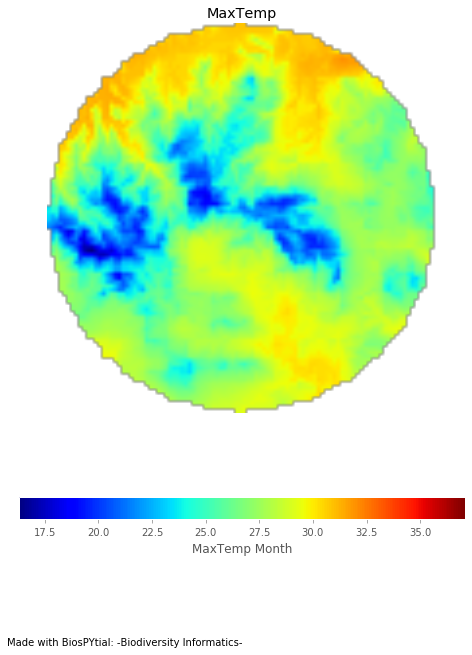

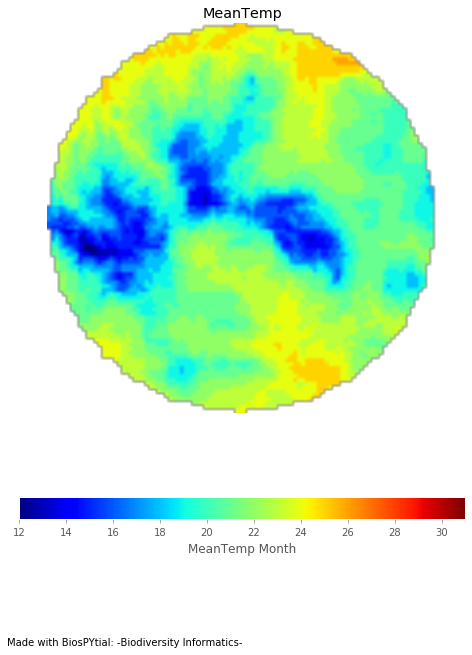

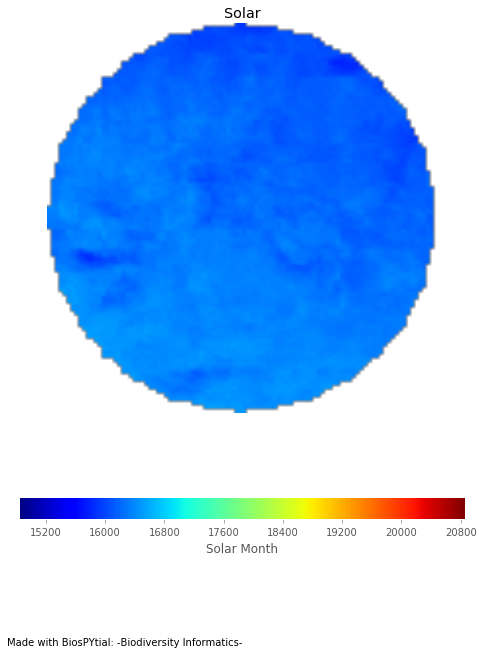

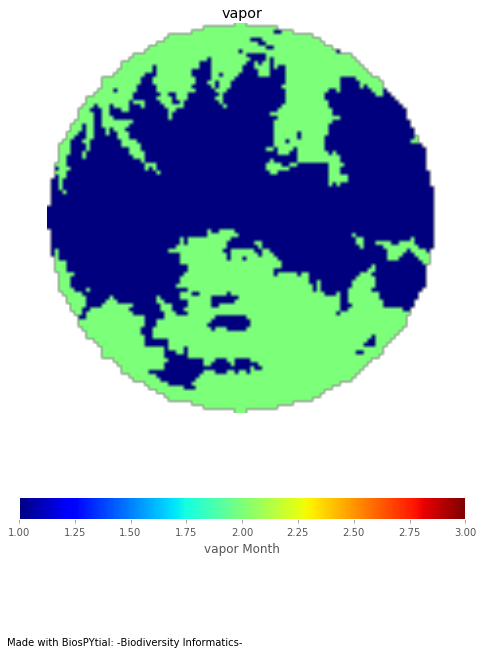

In [34]:
maxtemp = datasets[0][5]
meantemp = datasets[0][3]
solar = datasets[0][2]
vaporpres = datasets[0][6]
maxtemp.display_field(title='MaxTemp')
meantemp.display_field(title='MeanTemp')
solar.display_field(title='Solar')
vaporpres.display_field(title='vapor')


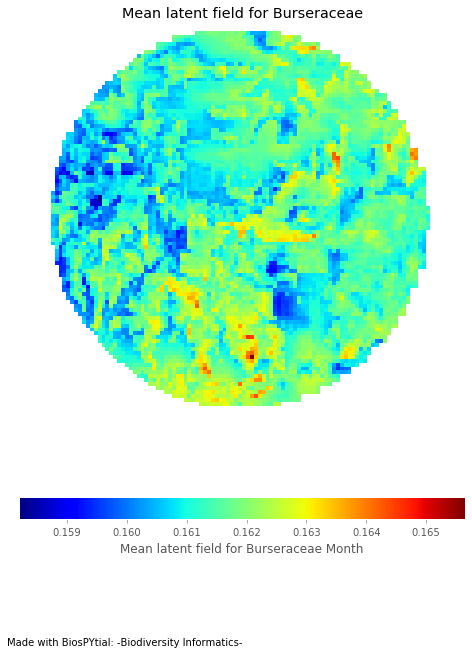

In [50]:
polys3 = datasets[0][3]
elevation = polys3
map_ = RasterContainer(predictions.mean_sample.values,exponential_fam='Bernoulli',use_metadata_from=elevation.rasterdata)
map_.display_field(band=2,origin='Lower',title='Mean latent field for Burseraceae',interpolation='None')
#map_.exportToGeoTiff('sample_effort_p3')
map_.exportToGeoTiff('burseraceae_mean_p4_wosef')

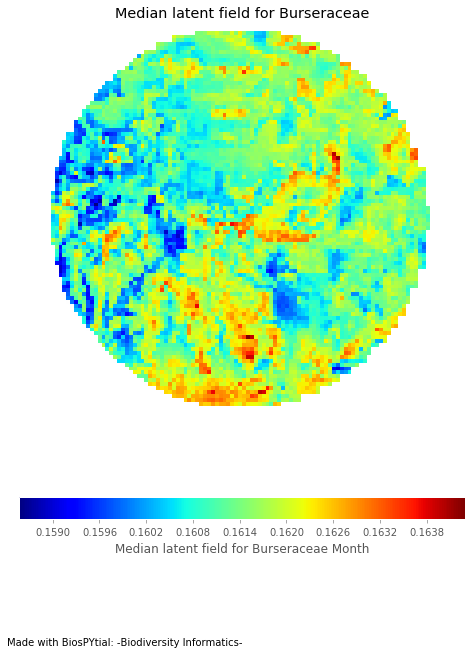

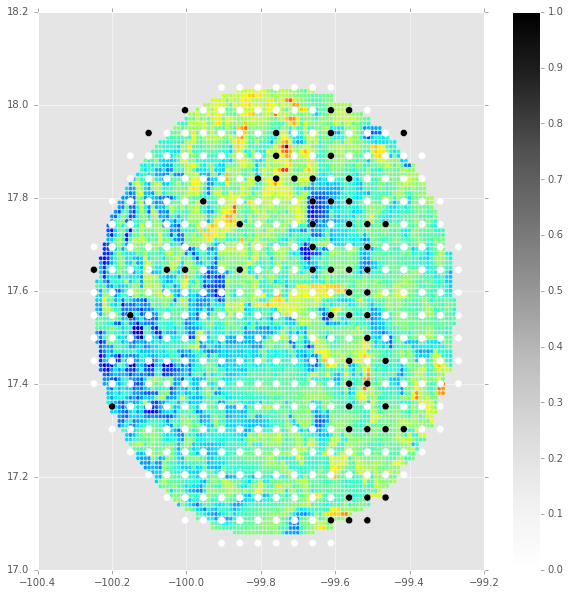

In [58]:
map_ = RasterContainer(predictions.median_.values,exponential_fam='Bernoulli',use_metadata_from=elevation.rasterdata)
map_.display_field(band=2,origin='Lower',title='Median latent field for Burseraceae',interpolation='None')
plt.scatter(predictions.Longitude,predictions.Latitude,c=predictions.mean_sample)
plt.scatter(TDF.Longitude,TDF.Latitude,c=TDF.Burseraceae,cmap=plt.cm.Greys,s=50)
plt.colorbar()
#map_.exportToGeoTiff('sample_effort_p3')
#map_.exportToGeoTiff('burseraceae_median_p4_wosef')

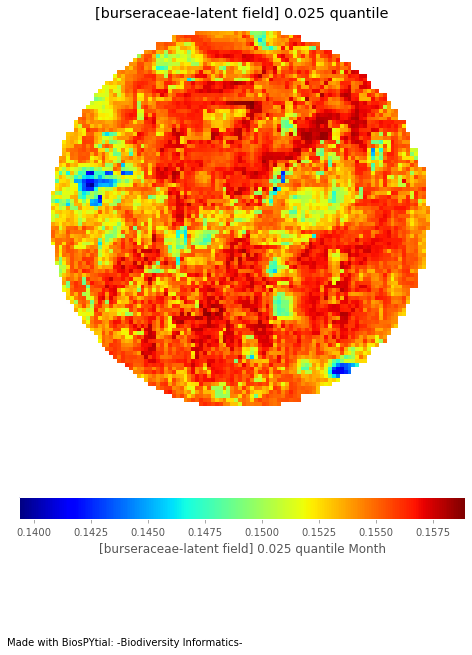

In [68]:
map_ = RasterContainer(predictions.q_025.values,exponential_fam='Bernoulli',use_metadata_from=elevation.rasterdata)
map_.display_field(band=2,origin='Lower',title='[burseraceae-latent field] 0.025 quantile' ,interpolation='None')
#map_.exportToGeoTiff('burseraceae_pex05_p4_wosef')

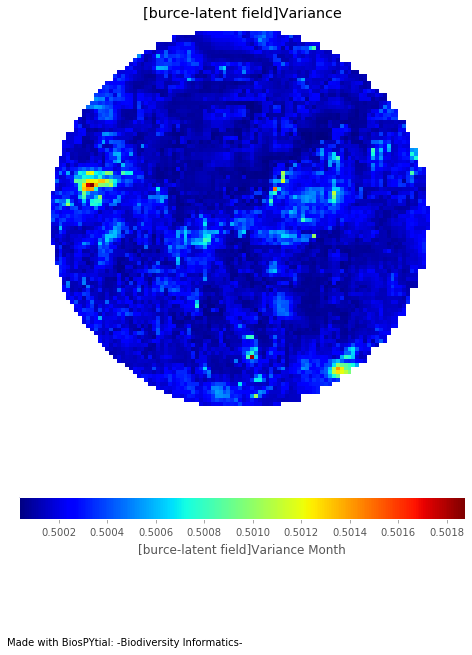

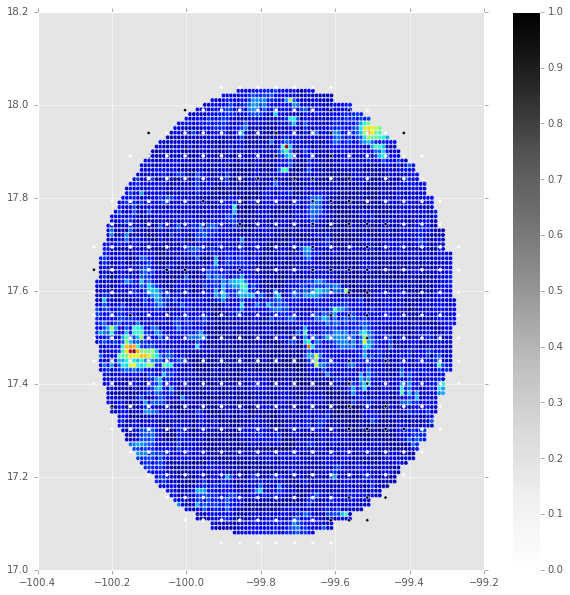

In [61]:
## For the variance
map_ = RasterContainer(predictions.vari.values,exponential_fam='Bernoulli',use_metadata_from=elevation.rasterdata)
map_.display_field(band=2,origin='Lower',title='[burce-latent field]Variance',interpolation='None' )
plt.scatter(predictions.Longitude,predictions.Latitude,c=predictions.vari)
plt.scatter(TDF.Longitude,TDF.Latitude,c=TDF.Burseraceae,cmap=plt.cm.Greys,s=10)
plt.colorbar()
map_.exportToGeoTiff('burseraceae_var_p4_wosef')

In [130]:
## Export to geotif to display in GIS
population.exportToGeoTiff('covariate-population-p4')
dist_2_road.exportToGeoTiff('covariate-dist-2-road-p4')